##Nematode Embryo Stage Classification: Prediction Notebook##
This code classifies a given nematode embryo during first embryonic division in to four annotated stages as described in [].

#### Requirements: 
1. A folder containing individual frames of a test time-series. Individual file name should end with frame number, ex: '/content/CB2/frame0.tif'. Modify the **get_frame** function if file names are not in format '*frame{frame number}.tif*'. 

In [30]:
import os
import pandas as pd 
import numpy as np 
import glob 
import torch 
import torch.nn as nn 
import PIL
from torchvision import transforms
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from PIL import Image
from torch.utils.data import DataLoader, WeightedRandomSampler
import cv2

In [28]:
# required functions 
def get_class(path_file):
    string_path = path_file.split('/')
    return string_path[-2]
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(([0.4817]),([0.1495]))])
def image_to_tensor(file_path):
    image= Image.open(file_path)
    image=  image.resize((112,74))
    image = PIL.ImageOps.grayscale(image)
    image_tensor = transform(image)
    return image_tensor 

def get_frame(path_file):
    string_path = path_file.split('/')
    sp_name = string_path[-1].split('.')[0].split('e')
    #print(sp_name)
    return int(sp_name[1]) 

color_select = ['#1f77b4','#ff7f0e', '#2ca02c','#E50000']
def get_color_array(color_select, dataf, choice):
    if choice:
        array = dataf['Ensemble'].astype('int')
        color_array = [color_select[x] for x in array]

    else:
        array = dataf['model_class1'].astype('int')
        color_array = [color_select[x] for x in array]
    return color_array



In [15]:
test_files = '/content/CB' # replace the uploaded folder her 

all_files = glob.glob(test_files + '/**' + '/*.tif', recursive = True)
print('Number of files found {}'.format(len(all_files)))
test_df = pd.DataFrame(all_files, columns = {'Filepath'})
#print(test_df.head())

test_df['frame_number']= test_df.apply(lambda row: get_frame(row['Filepath']), axis = 1)
test_df = test_df.sort_values(by='frame_number').reset_index(drop=True)
#for i in range(4):
    #test_df['model{}'.format(i+1)] = np.zeros(len(test_df))
test_df.head()

Number of files found 781


,Filepath,frame_number
0,/content/CB/frame0.tif,0
1,/content/CB/frame2.tif,2
2,/content/CB/frame3.tif,3
3,/content/CB/frame4.tif,4
4,/content/CB/frame5.tif,5


## Create the model 

In [16]:
class DenseNematode_v2(nn.Module): 
    def __init__(self, num_classes): 
        super(DenseNematode_v2, self).__init__() 
        self.relu = nn.ReLU(inplace= True)
        self.conv1  = nn.Conv2d(1, 16, kernel_size= 5 , stride=1, padding= 2) # output is [1,1,20,20]
        
        self.num_classes = num_classes 
        self.avg_pool_1 = nn.AvgPool2d(kernel_size =2 , stride = 2, padding =0)
        self.avg_pool_2 = nn.AvgPool2d(kernel_size =4 , stride = 4, padding =0)
        self.avg_pool_3 = nn.AvgPool2d(kernel_size =8 , stride = 8, padding =0)
        self.avg_pool_4 = nn.AvgPool2d(kernel_size = 16, stride =16, padding=0)
        
        
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3 ,stride=1 ,padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size  = 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv2d(128,128, kernel_size = 3, stride = 1, padding =1)
        self.conv6 = nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding= 1)
        self.one_D = nn.Conv2d(256, self.num_classes, kernel_size = 1) 
        self.bn1 = nn.BatchNorm2d(1) 
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(16)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(64)
        self.bn6 = nn.BatchNorm2d(128)
        self.bn7 = nn.BatchNorm2d(256)
        
        self.dropout = nn.Dropout(0.1)    
        self.adapt_Average = nn.AdaptiveAvgPool2d((1,1))
        #self.linear = nn.Linear(512, 4)
        
    def forward(self, x): 
        conv1 = self.bn1(x)
        conv1 = self.bn2(self.relu(self.conv1(x))) # 40*40
        conv1_1 = self.avg_pool_1(conv1) # 20*20
        conv1_2 = self.avg_pool_2(conv1) # 10*10
        conv1_3 = self.avg_pool_3(conv1) # 5*5 
        conv1_4 = self.avg_pool_4(conv1)
        # Reduce the dimensions 
        
        conv2  = self.bn3(self.relu(self.conv2(conv1)))  # 40*40
        conv2_1 = self.avg_pool_1(conv2) # 20*20
        conv2_2 = self.avg_pool_2(conv2) # 10*10 
        conv2_3 = self.avg_pool_3(conv2) # 5*5 
        conv2_4 = self.avg_pool_4(conv2)
        
        
        
        c1_dense = self.relu(torch.cat([conv1_1, conv2_1], 1))# 20*20 
        c1_dense = self.dropout(c1_dense)
        
        conv3 = self.bn4(self.relu(self.conv3(c1_dense))) # 20*20 
        conv3_1 = self.avg_pool_1(conv3) # 10*10
        conv3_2 = self.avg_pool_2(conv3)
        conv3_3 = self.avg_pool_3(conv3)
        
        c2_dense = self.relu(torch.cat([conv1_2, conv2_2, conv3_1], 1)) #10*10 
        c2_dense = self.dropout(c2_dense)
        
        conv4 = self.bn5(self.relu(self.conv4(c2_dense))) #10*10
        conv4_1 = self.avg_pool_1(conv4) # 5*5 
        conv4_2 = self.avg_pool_2(conv4) # 2.5 * 2.5
        
        c3_dense = self.relu(torch.cat([conv1_3, conv2_3, conv3_2, conv4_1], 1)) #5*5
        c3_dense = self.dropout(c3_dense)
        
        conv5 = self.bn6(self.relu(self.conv5(c3_dense))); 
        conv5_1 = self.avg_pool_1(conv5)
        
        c4_dense = self.relu(torch.cat([conv1_4, conv2_4, conv3_3, conv4_2, conv5_1], 1))
        c4_dense = self.dropout(c4_dense)
        
        conv6=  self.bn7(self.relu(self.conv6(c4_dense)))
        
        out = self.relu(self.one_D(conv6)) 
        #sprint(out.shape)
        out = self.adapt_Average(out)
        out = torch.flatten(out ,1)
        return out

In [18]:
# Load all the models 

class_list = ['Spindle_centering', 'Centration_rotation', 'Spindle_displacement',
       'Cytokinesis']

#model_fold_1 = '/content/sample_data/resnet18.pt'
model_fold_1 = '/content/nematodeNet.pt' 

all_models = [model_fold_1]

valid_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(([0.4817]), 
                                                           ([0.1495]))])
# Write  a predict function 
for i , model_path in enumerate(all_models):
    model = DenseNematode_v2(4)
    model.load_state_dict(torch.load(model_path, map_location= 'cpu'))
    model.eval()
    clas_pred = [] 
    with torch.no_grad():
        for rows in test_df.iterrows():
            image_tensor = image_to_tensor(rows[1]['Filepath'])
            image_tensor = image_tensor.unsqueeze(dim=0)
            pred_out = model(image_tensor)
            #pred_out = np.argmax(pred_out.cpu(), axis  = 1).tolist()
            pred_out = pred_out.cpu().tolist()
            for outt in pred_out:
                clas_pred.append(outt)
    test_df['model{}'.format(i+1)]  = clas_pred 
    test_df['model_class{}'.format(i+1)] = test_df.apply(lambda row : np.argmax(row['model{}'.format(i+1)]), axis =1)
# Store all predictions 

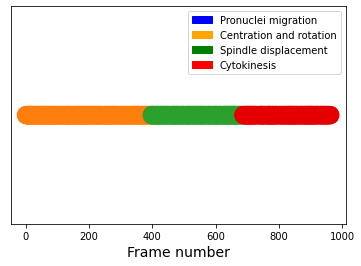

In [36]:
plt.scatter(test_df['frame_number'], [0] * test_df.shape[0], c = get_color_array(color_select, test_df,0),
               s = 300)
blue = mpatches.Patch(color='blue', label='Pronuclei migration')
green = mpatches.Patch(color='green', label='Spindle displacement')
orange = mpatches.Patch(color='orange', label='Centration and rotation')
red = mpatches.Patch(color='red', label='Cytokinesis')


plt.yticks([])
plt.xlabel('Frame number', fontsize= 14  )
plt.legend(handles=[blue,orange,green, red])
plt.show()